## Notebook to look at billy barr historic daily snow fall

To do:

1) PDF of daily snow fall
- create PDF of snowfall events from billy barr data X
- do the same for butte snotel site X

2) Identify late December storm in PDF
- mark out where we see these most (still need to work on this)

3) Look at biggest storms and identify origin
- look at precipitable water
- integrated vapor transport (if I can find this)
- geopotential height and anomolies for these periods

4) Look at how much big storms (10th perctile) account for annual snowfall

5) Look at the meadian snowfall day, what do these days look like synoptically?
- upper level hgts
- sonde profiles
- precip


In [2]:
# Packages to load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import ulmo
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from pyproj import Geod
import datetime as dt

import os

In [3]:
base_url = 'https://zenodo.org/record/6426160/files/'
fn = 'data.dat'

url = base_url+fn

outdir = '/storage/dlhogan/sos/data/'
    
if not os.path.exists(outdir+fn):
    !wget -nc -P {outdir} {url}

In [4]:
# Load billy barr data
filepath = outdir+fn
bb_data = pd.read_table(filepath, delimiter=',', header=1).dropna()
units = bb_data.loc[0].to_list()

bb_data = bb_data.drop(0, axis=0)
bb_data['Datetime'] = pd.to_datetime(bb_data['Date/Time'], format='%Y%m%d%H%M')
bb_data = bb_data.set_index('Datetime', drop=True).drop('Date/Time', axis=1)

/home/dlhogan/.conda/envs/py3_new/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
units_dict = dict(zip(bb_data.columns,units[1:]))

In [6]:
all_snowfall_data = bb_data[' Snow  '].astype('float')
all_snowfall_data_filtered = all_snowfall_data[(all_snowfall_data > 0) & (all_snowfall_data < 3000)]
all_snowfall_data.index = pd.to_datetime(all_snowfall_data.index)

In [7]:
med_daily_snowdepth_data = all_snowfall_data_filtered.groupby(all_snowfall_data_filtered.index.date).max()

In [8]:
# set 1 cm snowfall threshold and maximum of 2 meters of snowfall over a day
daily_snowfall_mm = med_daily_snowdepth_data.diff(1)
daily_snowfall_mm = daily_snowfall_mm[(daily_snowfall_mm > 10) & (daily_snowfall_mm < 1000)]

In [9]:
daily_snowfall_cm = daily_snowfall_mm.loc[slice(dt.date(2009,1,1),dt.date(2022, 1, 1))] / 10

In [10]:
# this is the CUAHSI API endpoint
# http://his.cuahsi.org/wofws.html
wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'

# identify SNOTEL site locations
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [11]:
# convert to pandas dataframe from dictionary and drop na values
sites_df = pd.DataFrame.from_dict(sites, orient='index').dropna()

# clean up dataframe and prepare point geometry objects, need x and y locs
# do this by creating a new column (geometry) and pulling lat and long info and use Point package to pull info from dict
sites_df['geometry']=[Point(float(loc['longitude']),float(loc['latitude'])) for loc in sites_df['location']]
sites_df = sites_df.drop(columns='location')
sites_df = sites_df.astype({'elevation_m':float})

# gathers all snotel sites
sites_gdf_all = gpd.GeoDataFrame(sites_df, crs='EPSG:4326')


In [12]:

#Define the ellipsoid to use for calculations
geod = Geod(ellps="WGS84")

#Compute geodetic distance between first and last point in a GeoDataFrame
#Return the distance and azimuth and back azimuth (degrees clockwise from north)
def geodetic_az_dist(gdf):
    distances = []
    for i in gdf.index:
    #Extract the points
        p0 = {'lat':38.9592, 'lon':-106.9898}
        p1 = gdf.loc[i].geometry
        #Compute the geodesic azimuth, back azimuth and distance
        az, backaz, dist = geod.inv(p0['lon'], p0['lat'], p1.x, p1.y)
        distances.append(dist / 1000)
    gdf['dist_to_gothic'] = distances
    return gdf

In [13]:
sites_gdf_all = geodetic_az_dist(sites_gdf_all)

In [14]:
snotel_near_gothic = sites_gdf_all[sites_gdf_all['dist_to_gothic'] < 10]

In [15]:
# snow and swe variables
met_vars = ['SNOTEL:SNWD_D','SNOTEL:WTEQ_D']
today = dt.datetime.today().strftime('%Y-%m-%d')
# function will take in a sitecode, variable code, start and end date and return variable data for that range and location as df
def snotel_fetch(sitecode, variablecode, start_date='1950-01-01', end_date=today):
    values_df = None
    sitename = 'Null'
    try:
        # start by requesting data from the server
        #print('Requesting Data from Server...')
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl,sitecode, variablecode, start=start_date, end=end_date)
        # return name of station
        sitename = site_values['site']['name']
        # convert to pandas dataframe
        values_df = pd.DataFrame.from_dict(site_values['values'])
        # parse the datetime values to Pandas Timestamp object
        #print('Cleaning Data...')
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=False) # turned to false for excel export
        # set df index to datetime
        values_df = values_df.set_index('datetime')
        # convert values to float and replace -9999 with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999,np.nan)
        # rename values column after variable code
        values_df.rename(columns = {'value':variablecode}, inplace = True)
        # remove lower quality records
        values_df = values_df[values_df['quality_control_level_code']=='1'][variablecode] 
        print('Done!')
    except:
        print('Unable to fetch %s' % variablecode)
    return values_df, sitename

In [16]:
# gets station output for specified stations
def getStation_output(sitecode, variables=met_vars):
    site_snotel = pd.DataFrame()
    sitename = 'Null'
    for var in variables:
        print('Fetching {0} for {1}'.format(var, sitecode))
        tmp, sitename = snotel_fetch(sitecode,var)
        if (tmp is not None) and (site_snotel is not None):
            
            site_snotel[sitename+' '+var] = tmp
        else:
            site_snotel = None
        site_snotel.rename(columns = {var:sitename+' '+var}, inplace = True)
    return site_snotel, sitename

In [17]:
outpath = None # change path to preferred output location
# outputs two dataframes, one for depth and the other for swe
dfs = []
for site_code in snotel_near_gothic.index:
    df, sitename = getStation_output(site_code)
    dfs.append(df)

Fetching SNOTEL:SNWD_D for SNOTEL:380_CO_SNTL
Done!
Fetching SNOTEL:WTEQ_D for SNOTEL:380_CO_SNTL
Done!
Fetching SNOTEL:SNWD_D for SNOTEL:737_CO_SNTL
Done!
Fetching SNOTEL:WTEQ_D for SNOTEL:737_CO_SNTL
Done!


In [18]:
snotel_data_near_gothic = dfs[1].join(dfs[0]) * 2.54
mask = (snotel_data_near_gothic.diff(1) < 100) & (snotel_data_near_gothic.diff(1) > -100) & (snotel_data_near_gothic < 375)
snotel_data_near_gothic_filtered = snotel_data_near_gothic[mask]

array([[<AxesSubplot:title={'center':'Schofield Pass SNOTEL:SNWD_D'}>,
        <AxesSubplot:title={'center':'Schofield Pass SNOTEL:WTEQ_D'}>],
       [<AxesSubplot:title={'center':'Butte SNOTEL:SNWD_D'}>,
        <AxesSubplot:title={'center':'Butte SNOTEL:WTEQ_D'}>]],
      dtype=object)

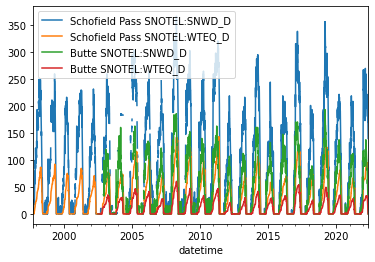

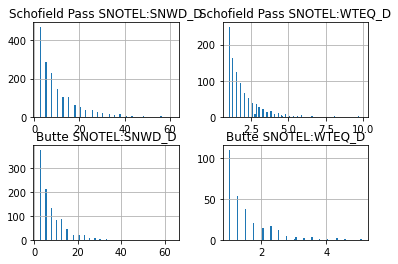

In [19]:
snotel_data_near_gothic_filtered.plot()
snotel_data_near_gothic_filtered.diff(1)[snotel_data_near_gothic_filtered.diff(1)>1].hist(bins=100)

In [20]:
snotel_daily_snowfall_schofield = snotel_data_near_gothic.diff(1)[snotel_data_near_gothic_filtered.diff(1)>1][['Schofield Pass SNOTEL:SNWD_D']].dropna()
snotel_daily_snowfall_butte = snotel_data_near_gothic.diff(1)[snotel_data_near_gothic_filtered.diff(1)>1][['Butte SNOTEL:SNWD_D']].dropna()
bb_daily_snowfall = daily_snowfall_cm

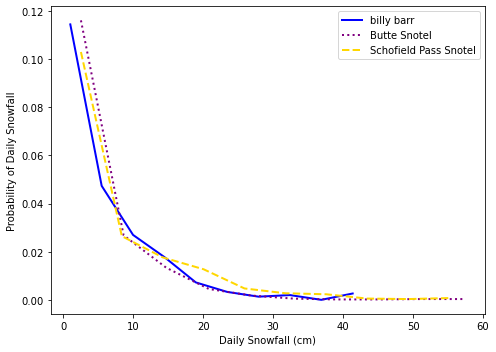

In [21]:
import scipy.stats as stats
# B.3. Plot PDFs
# set up subplots
fig, ax = plt.subplots(1,1, figsize=(7,5), tight_layout=True)
colour = ['b','purple','gold']
style = ['solid','dotted','dashed']
name = ['billy barr', 'Butte Snotel', 'Schofield Pass Snotel']
# for loop used to plot histograms for each time series of Sauk River peak data
for i,df in enumerate([bb_daily_snowfall, snotel_daily_snowfall_butte, snotel_daily_snowfall_schofield]):
    # Compute a histogram, specifying density=True to get normalized values (integral=1)
    # Reference 3
    counts, bin_edges = np.histogram(df, bins=10, density=True)# using density=True to normalize, and the square root method to determine number of bins
    ax.plot(bin_edges[:-1], 
             counts,
             color=colour[i],
             ls=style[i],
             lw=2,
             label=name[i])
# Plot specifications
ax.ticklabel_format(style='plain')
ax.set_xlabel('Daily Snowfall (cm)')
ax.set_ylabel('Probability of Daily Snowfall')
ax.legend()

In [22]:
# we will aslo need this 1d interpolation function
from scipy.interpolate import interp1d

In [23]:
snotel_daily_snowfall_butte['Butte SNOTEL:SNWD_D'].idxmax()

Timestamp('2002-12-14 00:00:00')

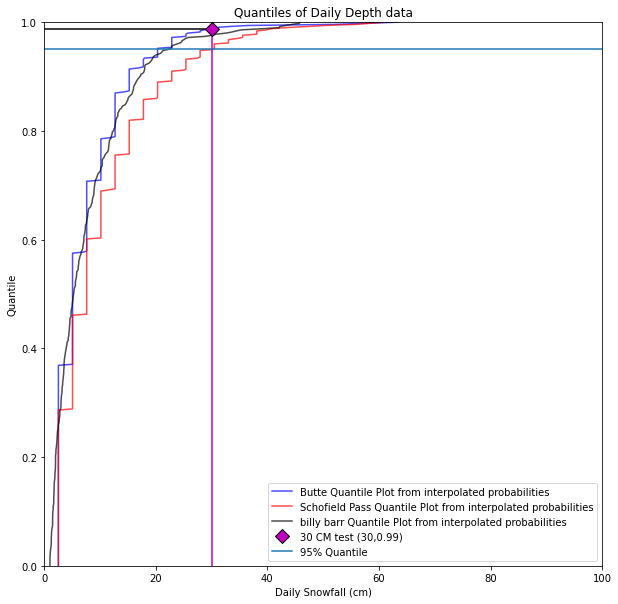

In [24]:
plt.figure(figsize=(10,10))
# We can also create these by picking arbitrary quantile values, then using the scipy.stats.mstats.mquantiles function
quantiles = np.linspace(0,1,500) # 100 quantile values linearly spaced between 0 and 1
plt.plot(stats.mstats.mquantiles(snotel_daily_snowfall_butte['Butte SNOTEL:SNWD_D'], quantiles), quantiles, 
         'b', label='Butte Quantile Plot from interpolated probabilities', alpha=0.7)
plt.plot(stats.mstats.mquantiles(snotel_daily_snowfall_schofield['Schofield Pass SNOTEL:SNWD_D'], quantiles), quantiles, 
         'r', label='Schofield Pass Quantile Plot from interpolated probabilities', alpha=0.7)
plt.plot(stats.mstats.mquantiles(bb_daily_snowfall, quantiles), quantiles, 
         'k', label='billy barr Quantile Plot from interpolated probabilities', alpha=0.7)

bb_snowfall_ordered = stats.mstats.mquantiles(snotel_daily_snowfall_butte['Butte SNOTEL:SNWD_D'], quantiles)
# When Slide Canyon has SWE equal to it's median, how much snow can we expect at Blue Canyon?
snowfall_test = 30
# Create a linear interpolation object based on these values (this lets us look up any value, x, and get back the y value)
f_snowfall = interp1d(bb_snowfall_ordered, quantiles)
snowfall_test_quantile = f_snowfall(snowfall_test)

plt.plot([snowfall_test, snowfall_test], [0, snowfall_test_quantile], c='m', linestyle='-')
# Plot a line from the test point to the y-axis
plt.plot([0, snowfall_test], [snowfall_test_quantile, snowfall_test_quantile], c='k', linestyle='-')
# Plot the test point value
plt.plot(snowfall_test,snowfall_test_quantile,'D', markerfacecolor='m', markeredgecolor='k',markersize=10, label='{} CM test ({},{})'.format(snowfall_test,snowfall_test, np.round(snowfall_test_quantile,2)))
# Plot a line from the x-axis to the test point

plt.axhline(0.95, label= '95% Quantile')

plt.ylabel('Quantile')
plt.xlabel('Daily Snowfall (cm)')
plt.xlim((0,100))
plt.ylim((0,1))
plt.title('Quantiles of Daily Depth data')
plt.legend(loc="best");

Let's try looking at precip rather than deriving daily snowfall. May be a bit more reliable.
- not really, but we do have data from the gap that persists in the 
- more useful since we have last 6 years of data. Can use in conjuction with 

In [25]:
precip_mm = bb_data[' Precip'].astype('float')
precip_filtered_mm = precip_mm[(precip_mm>0) & (precip_mm<30)]
precip_winter_filtered_mm = precip_filtered_mm[(precip_filtered_mm.index.year >= 2016)]
# precip_winter_filtered_mm = precip_filtered_mm[(precip_filtered_mm.index.month.isin([11,12,1,2,3,4])) & (precip_filtered_mm.index.year >= 2016)]

daily_winter_precip_mm = precip_winter_filtered_mm.groupby(precip_winter_filtered_mm.index.date).sum()

<AxesSubplot:title={'center':'Daily precip'}, xlabel='Datetime'>

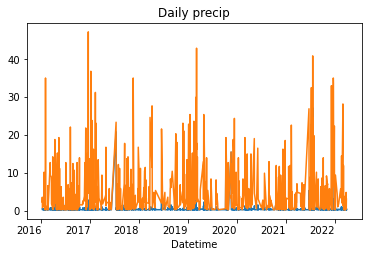

In [26]:
precip_winter_filtered_mm.plot(title='10 min precip')
daily_winter_precip_mm.plot(title='Daily precip')

In [27]:
daily_winter_precip_mm.loc[slice(dt.date(2021,12,15),dt.date(2021,12,31))]

2021-12-15     8.128
2021-12-16     0.254
2021-12-17     1.016
2021-12-23    35.052
2021-12-24    33.528
2021-12-25    10.668
2021-12-26     6.350
2021-12-27    14.478
2021-12-28    13.462
2021-12-29    11.176
2021-12-30    17.018
2021-12-31    22.352
Name:  Precip, dtype: float64

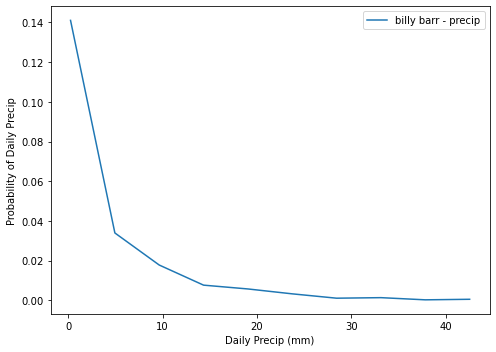

In [28]:
import scipy.stats as stats
# B.3. Plot PDFs
# set up subplots
fig, ax = plt.subplots(1,1, figsize=(7,5), tight_layout=True)

# for loop used to plot histograms for each time series of Sauk River peak data

counts, bin_edges = np.histogram(daily_winter_precip_mm, bins=10, density=True)# using density=True to normalize, and the square root method to determine number of bins
ax.plot(bin_edges[:-1], 
            counts,
            label='billy barr - precip')
# Plot specifications
ax.ticklabel_format(style='plain')
ax.set_xlabel('Daily Precip (mm)')
ax.set_ylabel('Probability of Daily Precip')
ax.legend()

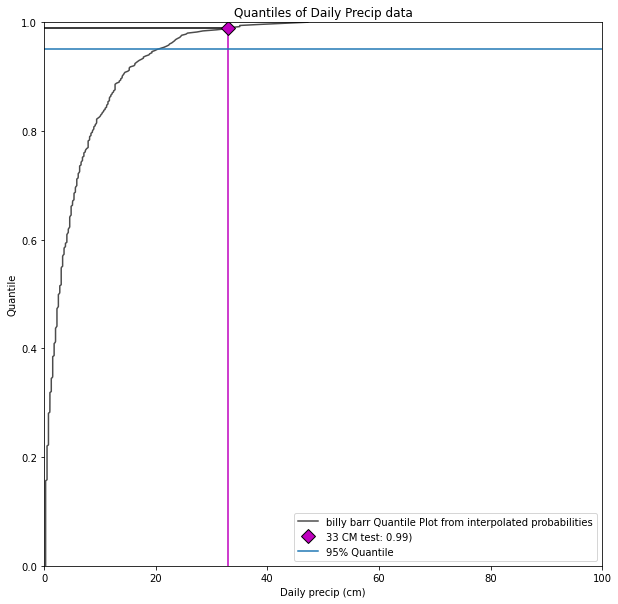

In [29]:
plt.figure(figsize=(10,10))
# We can also create these by picking arbitrary quantile values, then using the scipy.stats.mstats.mquantiles function
quantiles = np.linspace(0,1,500) # 100 quantile values linearly spaced between 0 and 1
plt.plot(stats.mstats.mquantiles(daily_winter_precip_mm, quantiles), quantiles, 
         'k', label='billy barr Quantile Plot from interpolated probabilities', alpha=0.7)

bb_precip_ordered = stats.mstats.mquantiles(daily_winter_precip_mm, quantiles)
# When Slide Canyon has SWE equal to it's median, how much snow can we expect at Blue Canyon?
precip_test = 33
# Create a linear interpolation object based on these values (this lets us look up any value, x, and get back the y value)
f_precip = interp1d(bb_precip_ordered, quantiles)
precip_test_quantile = f_precip(precip_test)

plt.plot([precip_test, precip_test], [0, precip_test_quantile], c='m', linestyle='-')
# Plot a line from the test point to the y-axis
plt.plot([0, precip_test], [precip_test_quantile, precip_test_quantile], c='k', linestyle='-')
# Plot the test point value
plt.plot(precip_test,precip_test_quantile,'D', markerfacecolor='m', markeredgecolor='k',markersize=10, label=f'{precip_test} CM test: {np.round(precip_test_quantile,2)})')
# Plot a line from the x-axis to the test point

plt.axhline(0.95, label= '95% Quantile')

plt.ylabel('Quantile')
plt.xlabel('Daily precip (cm)')
plt.xlim((0,100))
plt.ylim((0,1))
plt.title('Quantiles of Daily Precip data')
plt.legend(loc="best");

In [30]:
# filter events in top 95% quantile
daily_winter_precip_95th_mm = daily_winter_precip_mm[daily_winter_precip_mm >= daily_winter_precip_mm.quantile(0.95)]
daily_winter_precip_95th_mm.index = pd.to_datetime(daily_winter_precip_95th_mm.index)


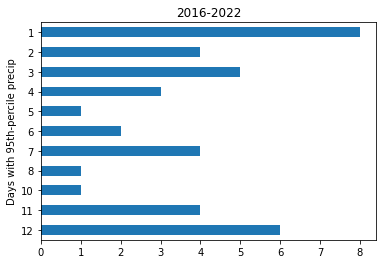

In [31]:
fig, ax = plt.subplots()
my_plot = daily_winter_precip_95th_mm.groupby(daily_winter_precip_95th_mm.index.month).count().plot.barh(ylabel='Month',
                                                                                            xlabel='Days with 95th-percile precip',
                                                                                            title='2016-2022', 
                                                                                            ax=ax).invert_yaxis()                                                                                           

In [32]:
daily_winter_precip_95th_mm.index.sort_values()

DatetimeIndex(['2016-01-31', '2016-08-04', '2016-11-27', '2016-12-16',
               '2017-01-04', '2017-01-05', '2017-01-08', '2017-01-09',
               '2017-01-11', '2017-02-07', '2017-02-11', '2017-07-12',
               '2017-11-17', '2018-03-23', '2018-04-07', '2018-06-17',
               '2018-10-02', '2018-11-24', '2018-11-30', '2019-01-06',
               '2019-01-16', '2019-02-14', '2019-03-02', '2019-03-03',
               '2019-03-06', '2019-04-28', '2019-04-29', '2019-05-01',
               '2019-12-14', '2021-02-12', '2021-06-24', '2021-07-12',
               '2021-07-22', '2021-07-25', '2021-12-09', '2021-12-23',
               '2021-12-24', '2021-12-31', '2022-03-05'],
              dtype='datetime64[ns]', freq=None)

Butte Snotel Location

In [47]:
# Note: this only takes into account differences in snow depth between 2-days, does not take into account total snowfall from hourly product or something more resolved...

# combine and add water year column
snotel_daily_snowfall = snotel_daily_snowfall_schofield.join(snotel_daily_snowfall_butte)
snotel_daily_snowfall['WY'] = snotel_daily_snowfall['Schofield Pass SNOTEL:SNWD_D'].index.to_period('Q-SEP').qyear

# get total snowfall for each winter (cm)
snowfall_water_year = snotel_daily_snowfall.groupby(snotel_daily_snowfall['WY']).sum()

# array of water years
water_years = snotel_daily_snowfall['WY'].unique()

# quantile to compare top storms
quant = 0.75
big_storm_snowfall ={}
cols = ['upper_10th_percentile_total','upper_10th_percentile_count', 'total_snowy_days', 'big_storm_percent_total', 'wy_accum', 'wy_std']
location = 'Butte SNOTEL:SNWD_D'
for wy in water_years:
    # mask by water year
    year_mask = snotel_daily_snowfall['WY'] == wy 
    snotel_year = snotel_daily_snowfall[year_mask]
    
    # total number of snowy days
    mask_nosnow = snotel_year[location] > 0
    snow_days = snotel_year[mask_nosnow][location].count()

    # each years snow total
    wy_snow_total = snowfall_water_year.loc[wy][location]
    
    # separate out quantile data
    quantile_mask = snotel_year[location] >= snotel_year[location].quantile(quant)

    # compute sum of big storms and count of big storms
    snowfall_total_upper_10th = snotel_year[quantile_mask].sum()
    snowfall_count_upper_10th = snotel_year[quantile_mask].count()
    big_storm_snowfall[wy] = [snowfall_total_upper_10th[location], snowfall_count_upper_10th[location], snow_days, 
                                snowfall_total_upper_10th[location]/wy_snow_total, wy_snow_total, snotel_year[quantile_mask][location].std()]
    


/tmp/ipykernel_29358/3765780918.py:37: RuntimeWarning: invalid value encountered in double_scalars
  snowfall_total_upper_10th[location]/wy_snow_total, wy_snow_total, snotel_year[quantile_mask][location].std()]


In [48]:
wy_snowfall_details = pd.DataFrame.from_dict(big_storm_snowfall, orient='index', columns=cols)
wy_snowfall_details = wy_snowfall_details.drop([1998,1999,2000,2001,2003,2002,2004,2005])

In [60]:
wy_snowfall_details.describe()

,upper_10th_percentile_total,upper_10th_percentile_count,total_snowy_days,big_storm_percent_total,wy_accum,wy_std
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,173.018824,10.588235,36.235294,0.570520,304.351765,5.880987
std,44.166816,2.152290,6.941986,0.049710,79.839655,2.112512
min,114.300000,7.000000,24.000000,0.500000,210.820000,3.016847
25%,129.540000,9.000000,34.000000,0.542169,228.600000,4.501626
50%,175.260000,10.000000,35.000000,0.563636,297.180000,5.471932
75%,200.660000,12.000000,39.000000,0.603659,347.980000,6.534787
max,251.460000,14.000000,51.000000,0.676471,452.120000,10.739659


In [36]:
import scipy.stats as stats

In [50]:
# quantile to compare top storms
median_storm_snowfall ={}
cols = ['wy_25th_percentile_snowfall','wy_75th_percentile_snowfall', 'total_snowy_days', 'snow_days_around_50th_percentile','snow_total', 'mad_percent_total']
location = 'Butte SNOTEL:SNWD_D'
for wy in water_years:
    if wy not in [1998,1999,2000,2001,2003,2002,2004,2005]:
        # mask by water year
        year_mask = snotel_daily_snowfall['WY'] == wy 
        snotel_year = snotel_daily_snowfall[year_mask]
        
        # total number of snowy days
        mask_nosnow = snotel_year[location] > 0
        snowy_days = snotel_year[mask_nosnow][location].count()
        
        snowy_days_25th = snotel_year[location].quantile(.25)
        snowy_days_75th = snotel_year[location].quantile(.75)

        snow_days_around_50th_percentile = snotel_year[(snotel_year[location] > snowy_days_25th) & (snotel_year[location] < snowy_days_75th)][location].count()
        snow_total = snotel_year[(snotel_year[location] > snowy_days_25th) & (snotel_year[location] < snowy_days_75th)][location].sum()
        
        # each years snow total
        wy_snow_total = snowfall_water_year.loc[wy][location]
        
        median_storm_snowfall[wy] = [snowy_days_25th, snowy_days_75th, snowy_days, snow_days_around_50th_percentile, snow_total, snow_total/wy_snow_total]

median_storm_snowfall_df = pd.DataFrame.from_dict(median_storm_snowfall, orient='index', columns=cols)

In [59]:
median_storm_snowfall_df.describe()

,wy_25th_percentile_snowfall,wy_75th_percentile_snowfall,total_snowy_days,snow_days_around_50th_percentile,snow_total,mad_percent_total
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,3.735294,10.795000,36.235294,14.470588,98.312941,0.318090
std,1.247625,2.289525,6.941986,4.810375,37.874593,0.062637
min,2.540000,7.620000,24.000000,7.000000,50.800000,0.196078
25%,2.540000,10.160000,34.000000,10.000000,68.580000,0.279070
50%,3.175000,10.160000,35.000000,14.000000,83.820000,0.335366
75%,5.080000,12.700000,39.000000,18.000000,121.920000,0.361842
max,5.080000,15.240000,51.000000,23.000000,175.260000,0.404494


Text(0, 0.5, 'Accumulated Snowfall (cm)')

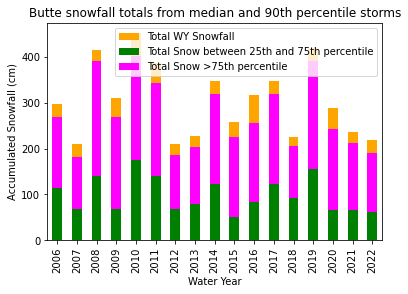

In [54]:
fig,ax = plt.subplots()
snowfall_water_year[location].drop([1998,1999,2000,2001,2003,2002,2004,2005]).plot.bar(label='Total WY Snowfall', color='orange', ax=ax)
median_storm_snowfall_df['snow_total'].plot.bar(ax=ax, label='Total Snow between 25th and 75th percentile', color='green')
wy_snowfall_details['upper_10th_percentile_total'].plot.bar(ax=ax, label='Total Snow >75th percentile', bottom=median_storm_snowfall_df['snow_total'], color='magenta')


ax.set_title(f'{location[:-14]} snowfall totals from median and 90th percentile storms')
ax.legend()
ax.set_xlabel('Water Year')
ax.set_ylabel('Accumulated Snowfall (cm)')


In [70]:
# Note: this only takes into account differences in snow depth between 2-days, does not take into account total snowfall from hourly product or something more resolved...

# combine and add water year column
snotel_daily_snowfall = snotel_daily_snowfall_schofield.join(snotel_daily_snowfall_butte)
snotel_daily_snowfall['WY'] = snotel_daily_snowfall['Schofield Pass SNOTEL:SNWD_D'].index.to_period('Q-SEP').qyear

# get total snowfall for each winter (cm)
snowfall_water_year = snotel_daily_snowfall.groupby(snotel_daily_snowfall['WY']).sum()

# array of water years
water_years = snotel_daily_snowfall['WY'].unique()

# quantile to compare top storms
quant = 0.75
big_storm_snowfall ={}
cols = ['upper_10th_percentile_total','upper_10th_percentile_count', 'total_snowy_days', 'big_storm_percent_total', 'wy_accum', 'wy_std']
location = 'Schofield Pass SNOTEL:SNWD_D'
for wy in water_years:
    # mask by water year
    year_mask = snotel_daily_snowfall['WY'] == wy 
    snotel_year = snotel_daily_snowfall[year_mask]
    
    # total number of snowy days
    mask_nosnow = snotel_year[location] > 0
    snow_days = snotel_year[mask_nosnow][location].count()

    # each years snow total
    wy_snow_total = snowfall_water_year.loc[wy][location]
    
    # separate out quantile data
    quantile_mask = snotel_year[location] >= snotel_year[location].quantile(quant)

    # compute sum of big storms and count of big storms
    snowfall_total_upper_10th = snotel_year[quantile_mask].sum()
    snowfall_count_upper_10th = snotel_year[quantile_mask].count()
    big_storm_snowfall[wy] = [snowfall_total_upper_10th[location], snowfall_count_upper_10th[location], snow_days, 
                                snowfall_total_upper_10th[location]/wy_snow_total, wy_snow_total, snotel_year[quantile_mask][location].std()]
    


Schofield Pass

In [71]:
wy_snowfall_details = pd.DataFrame.from_dict(big_storm_snowfall, orient='index', columns=cols)
wy_snowfall_details = wy_snowfall_details.drop([1998,2004])

In [72]:
# quantile to compare top storms
median_storm_snowfall ={}
cols = ['wy_25th_percentile_snowfall','wy_75th_percentile_snowfall', 'total_snowy_days', 'snow_days_around_50th_percentile','snow_total', 'mad_percent_total']
location = 'Schofield Pass SNOTEL:SNWD_D'
for wy in water_years:
    if wy not in [1998, 2004]:
        # mask by water year
        year_mask = snotel_daily_snowfall['WY'] == wy 
        snotel_year = snotel_daily_snowfall[year_mask]
        
        # total number of snowy days
        mask_nosnow = snotel_year[location] > 0
        snowy_days = snotel_year[mask_nosnow][location].count()
        
        snowy_days_25th = snotel_year[location].quantile(.25)
        snowy_days_75th = snotel_year[location].quantile(.75)

        snow_days_around_50th_percentile = snotel_year[(snotel_year[location] > snowy_days_25th) & (snotel_year[location] < snowy_days_75th)][location].count()
        snow_total = snotel_year[(snotel_year[location] > snowy_days_25th) & (snotel_year[location] < snowy_days_75th)][location].sum()
        
        # each years snow total
        wy_snow_total = snowfall_water_year.loc[wy][location]
        
        median_storm_snowfall[wy] = [snowy_days_25th, snowy_days_75th, snowy_days, snow_days_around_50th_percentile, snow_total, snow_total/wy_snow_total]

median_storm_snowfall_df = pd.DataFrame.from_dict(median_storm_snowfall, orient='index', columns=cols)

Text(0, 0.5, 'Accumulated Snowfall (cm)')

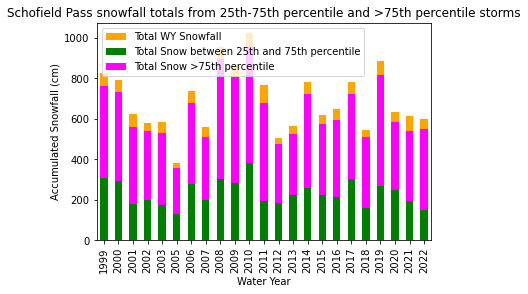

In [84]:
fig,ax = plt.subplots()
snowfall_water_year[location].drop([1998, 2004]).plot.bar(label='Total WY Snowfall', color='orange', ax=ax)
vbars1 = median_storm_snowfall_df['snow_total'].plot.bar(ax=ax, label='Total Snow between 25th and 75th percentile', color='green')
wy_snowfall_details['upper_10th_percentile_total'].plot.bar(ax=ax, label='Total Snow >75th percentile', bottom=median_storm_snowfall_df['snow_total'], color='magenta')


ax.set_title(f'{location[:-14]} snowfall totals from 25th-75th percentile and >75th percentile storms')
ax.legend()
ax.set_xlabel('Water Year')
ax.set_ylabel('Accumulated Snowfall (cm)')


What can I conclude from this? At Schofield Pass:
- Large storms (upper 90%) come through around 7 times per year (these could be consecutive days, did not check on this)
- These storms account for around 33% of the annual total snowfall for a year 
- It snows (most likely an undersestimate) around 70 days per year
- The median day (+/- mad) consists of around 3 +/- 1.5 inches of snow.
- The median day accounts for approximately 30% of the total snow that falls over a year and this happens around 32 times per year (or near 50% of snowy days)
- Thus, the median day and large storms account for a similar amount of total snowfall through the year

At Butte:
- Similar store but median day accounts for more of the total snowfall (55%). 
- Big storms still account for around 30%